# **covid-19-in-South-Korea**

*Author*: Huey Kim [Github](https://github.com/hwuiwon)

We will use [Data Science for COVID-19 dataset](https://www.kaggle.com/kimjihoo/coronavirusdataset) provided by DS4C at Kaggle.

## **List of Files**

*Encoding*: UTF-8

*   **Case.csv** (Data of COVID-19 infection cases)
*   **PatientInfo.csv** (Epidemiological data of COVID-19 patients)
*   **PatientRoute.csv** (Route data of COVID-19 patients)
*   **Region.csv** (Location and statistical data of the regions)
*   **SearchTrend.csv** (Trend data of the keywords searched in NAVER which is one of the largest portals)
*   **SeoulFloating.csv** (Data of floating population in Seoul, South Korea (from SK Telecom Big Data Hub))
*   **Time.csv** (Time series data of COVID-19 status)
*   **TimeAge.csv** (Time series data of COVID-19 status in terms of the age)
*   **TimeGender.csv** (Time series data of COVID-19 status in terms of gender)
*   **TimeProvince.csv** (Time series data of COVID-19 status in terms of the Province)
*   **Weather.csv** (Data of the weather in the regions)

### **Setting Directory Path**

In [0]:
DIR_PATH = '/content/drive/My Drive/Colab Notebooks/data/kr-corona-dataset/'

### **Setting Environment**

In [0]:
%config InlineBackend.figure_format = 'retina'

import os, copy, time, random;
import numpy as np;
import pandas as pd;
import seaborn as sns;
import matplotlib.pyplot as plt;

sns.set_style('darkgrid')

### **External Datasets**

**Population Distribution Data**

* [Ministry of the Interior and Safety](http://27.101.213.4/)

File Name: *PopulationDistribution.csv* (as of March)

Use this code to convert file with encoding **EUC-KR** to **UTF-8**.
```
iconv -f euc-kr -t utf-8 old.csv > new.csv
```

In [3]:
# Importing data: PopulationDistribution
pop_dist = pd.read_csv(os.path.join(DIR_PATH, 'PopulationDistribution.csv'))
pop_dist = pop_dist.iloc[:, np.r_[0, 1, 3:12, 14:15, 27]]
pop_dist.columns = ['location', 'total', '0s', '10s', '20s', '30s', '40s', '50s',
                   '60s', '70s', '80s', 'male_total', 'female_total']
pop_dist.head()

,location,total,0s,10s,20s,30s,40s,50s,60s,70s,80s,male_total,female_total
0,전국 (0000000000),"51,843,195","4,119,475","4,902,009","6,799,238","7,006,749","8,375,429","8,662,400","6,426,006","3,623,899","1,667,665","25,858,743","25,984,452"
1,서울특별시 (1100000000),"9,733,655","655,134","810,349","1,461,212","1,501,662","1,558,128","1,537,114","1,205,699","691,028","266,097","4,742,217","4,991,438"
2,부산광역시 (2600000000),"3,409,932","240,857","279,909","435,280","430,494","516,889","579,584","513,485","286,808","110,254","1,672,252","1,737,680"
3,대구광역시 (2700000000),"2,433,568","185,945","233,311","322,594","302,617","390,628","428,955","313,213","171,945","74,745","1,202,273","1,231,295"
4,인천광역시 (2800000000),"2,952,689","238,763","279,780","405,826","416,119","489,213","515,257","347,493","172,868","74,768","1,479,839","1,472,850"


## **By Gender**

In [4]:
# Importing data: Gender
gender = pd.read_csv(os.path.join(DIR_PATH, 'TimeGender.csv'))
gender.head(2)

,date,time,sex,confirmed,deceased
0,2020-03-02,0,male,1591,13
1,2020-03-02,0,female,2621,9


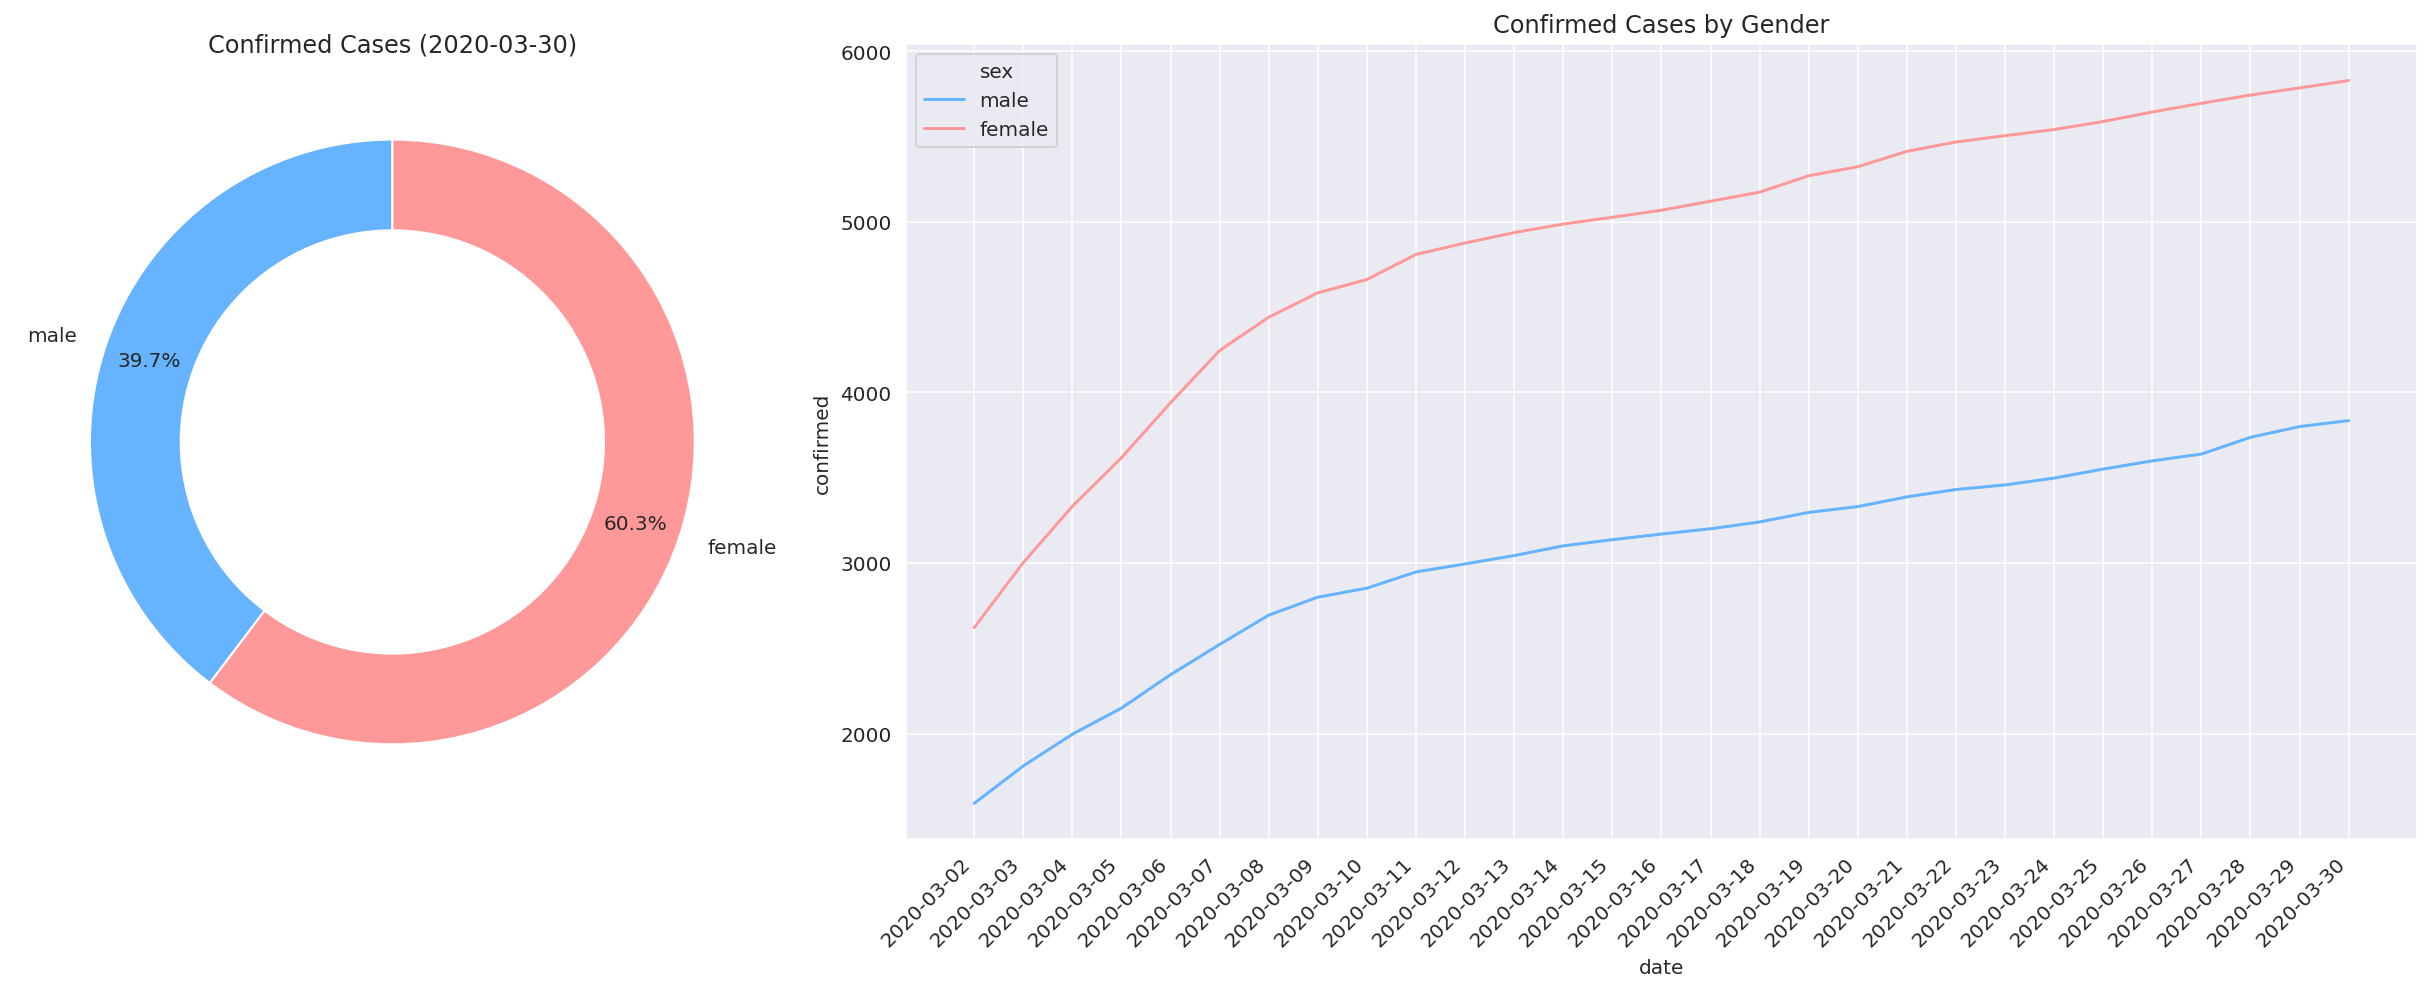

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17, 7), gridspec_kw={'width_ratios': [1, 2]})
sns.set_palette(['#66b3ff','#ff9999'])

# Donut plot of confirmed cases by gender
ax1.title.set_text('Confirmed Cases ({0})'.format(gender.iloc[-1, 0]))
ax1.pie(gender.confirmed[-2:], labels=['male', 'female'], autopct='%.1f%%',
        startangle=90, pctdistance=0.85)
ax1.add_artist(plt.Circle((0, 0), 0.7, fc='white'))

# Change in time of confirmed cases
ax2.title.set_text('Confirmed Cases by Gender')
sns.lineplot(data=gender, x='date', y='confirmed', hue='sex', ax=ax2)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

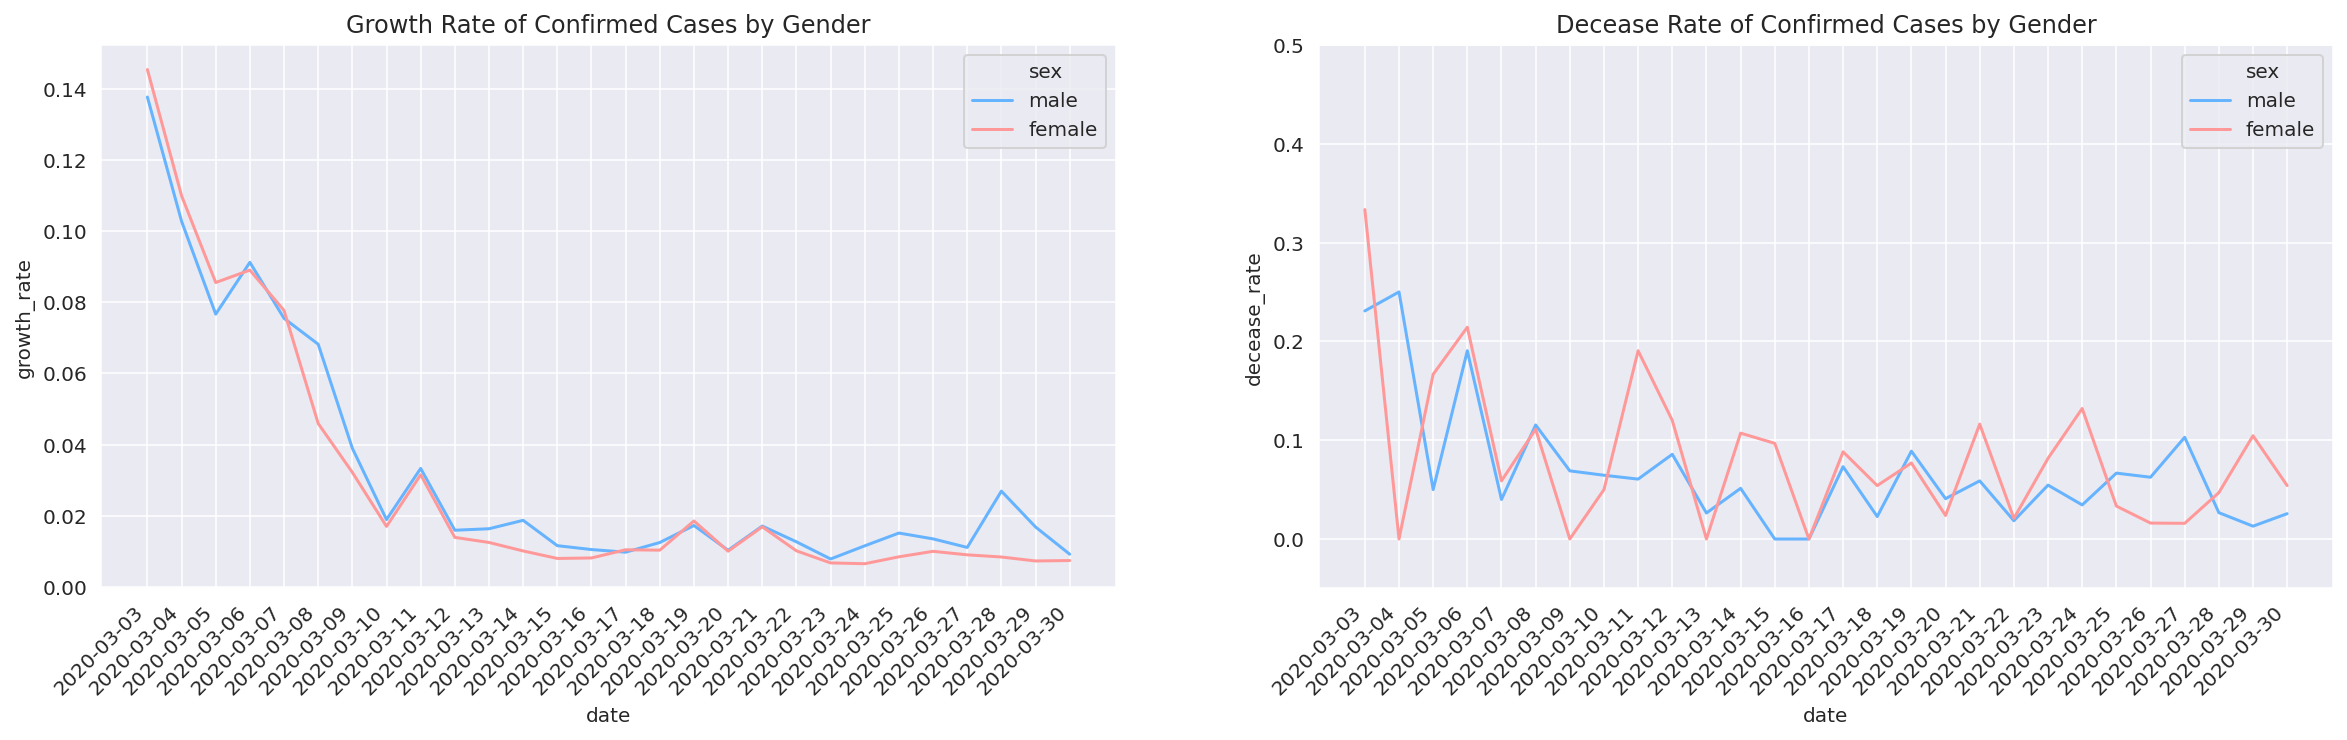

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Growth rate of confirmed cases (Index - male: even, female: odd)
ax1.title.set_text('Growth Rate of Confirmed Cases by Gender')
gender['growth_rate'] = gender.groupby('sex')[['confirmed']].pct_change()
sns.lineplot(data=gender, x='date', y='growth_rate', hue='sex', ax=ax1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Decease rate of confirmed cases
ax2.title.set_text('Decease Rate of Confirmed Cases by Gender')
# Limiting y axis range to reduce fluctuations in graph
ax2.set(ylim=(-0.05, 0.5))
gender['decease_rate'] = gender.groupby('sex')[['deceased']].pct_change()
sns.lineplot(data=gender, x='date', y='decease_rate', hue='sex', ax=ax2)
plt.xticks(rotation=45, ha='right')

plt.show()

### **Analysis**

1. More females are infected than males.
2. The growth rate of confirmed cases is similar regardless of genders.
3. Both genders show a similar trend of decease rate.

### **Conclusion**

Gender **isn't** a significant factor that influences the infection rate. (No correlation)<br>
The reason why more females were infected than men might be due to geological reasons or different lifestyles.

## **By Age**

In [7]:
# Importing data: Age
age = pd.read_csv(os.path.join(DIR_PATH, 'TimeAge.csv'))
print('Unique items: {0}'.format(len(age['age'].unique())))
age.head(9)

Unique items: 9


,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1
5,2020-03-02,0,50s,834,5
6,2020-03-02,0,60s,530,6
7,2020-03-02,0,70s,192,6
8,2020-03-02,0,80s,81,3


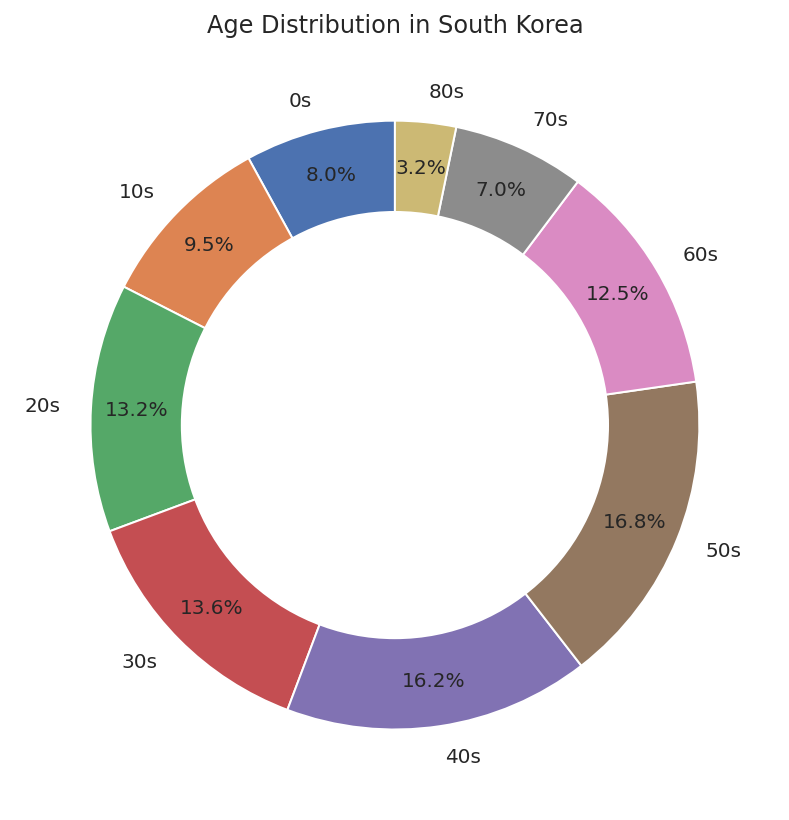

In [36]:
sns.set_palette('deep')
pop_dist_age = pop_dist.iloc[0, 2:11].str.replace(',', '')

# Population distribution by age
plt.figure(figsize=(7, 7))
plt.title('Age Distribution in South Korea')
plt.pie(pop_dist_age, labels=pop_dist_age.index, 
        autopct='%.1f%%', startangle=90, pctdistance=0.85)
plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.7, fc='white'))

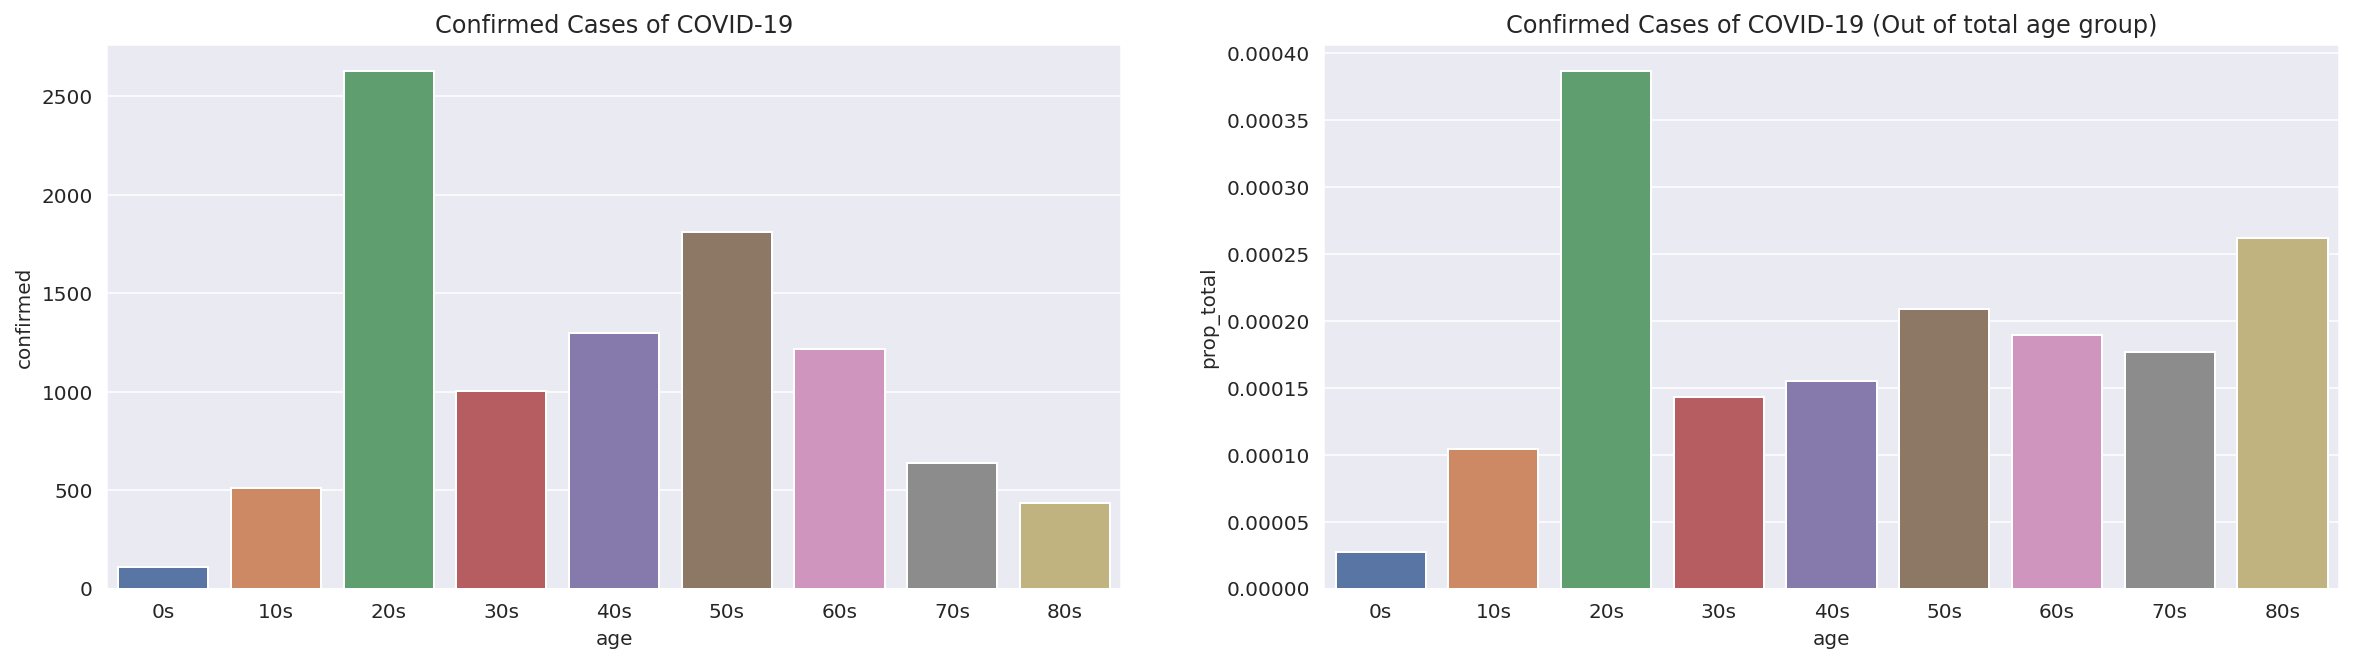

In [37]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Confirmed cases by age
ax1.title.set_text('Confirmed Cases of COVID-19')
sns.barplot(data=age[-9:], x='age', y='confirmed', ax=ax1)

# Create new column of total people in that age group
pop_dist_age = pop_dist.iloc[0, 2:11].str.replace(',', '')
age['age_total'] = np.tile(pop_dist_age, len(age) // len(pop_dist_age) + 1)[:len(age)]

# Create proportion column
age['prop_total'] = age['confirmed'] / age['age_total'].astype(float)

# Proportion of confirmed cases by age to total people in age group
ax2.title.set_text('Confirmed Cases of COVID-19 (Out of total age group)')
sns.barplot(data=age[-9:], x='age', y='prop_total', ax=ax2)

plt.show()

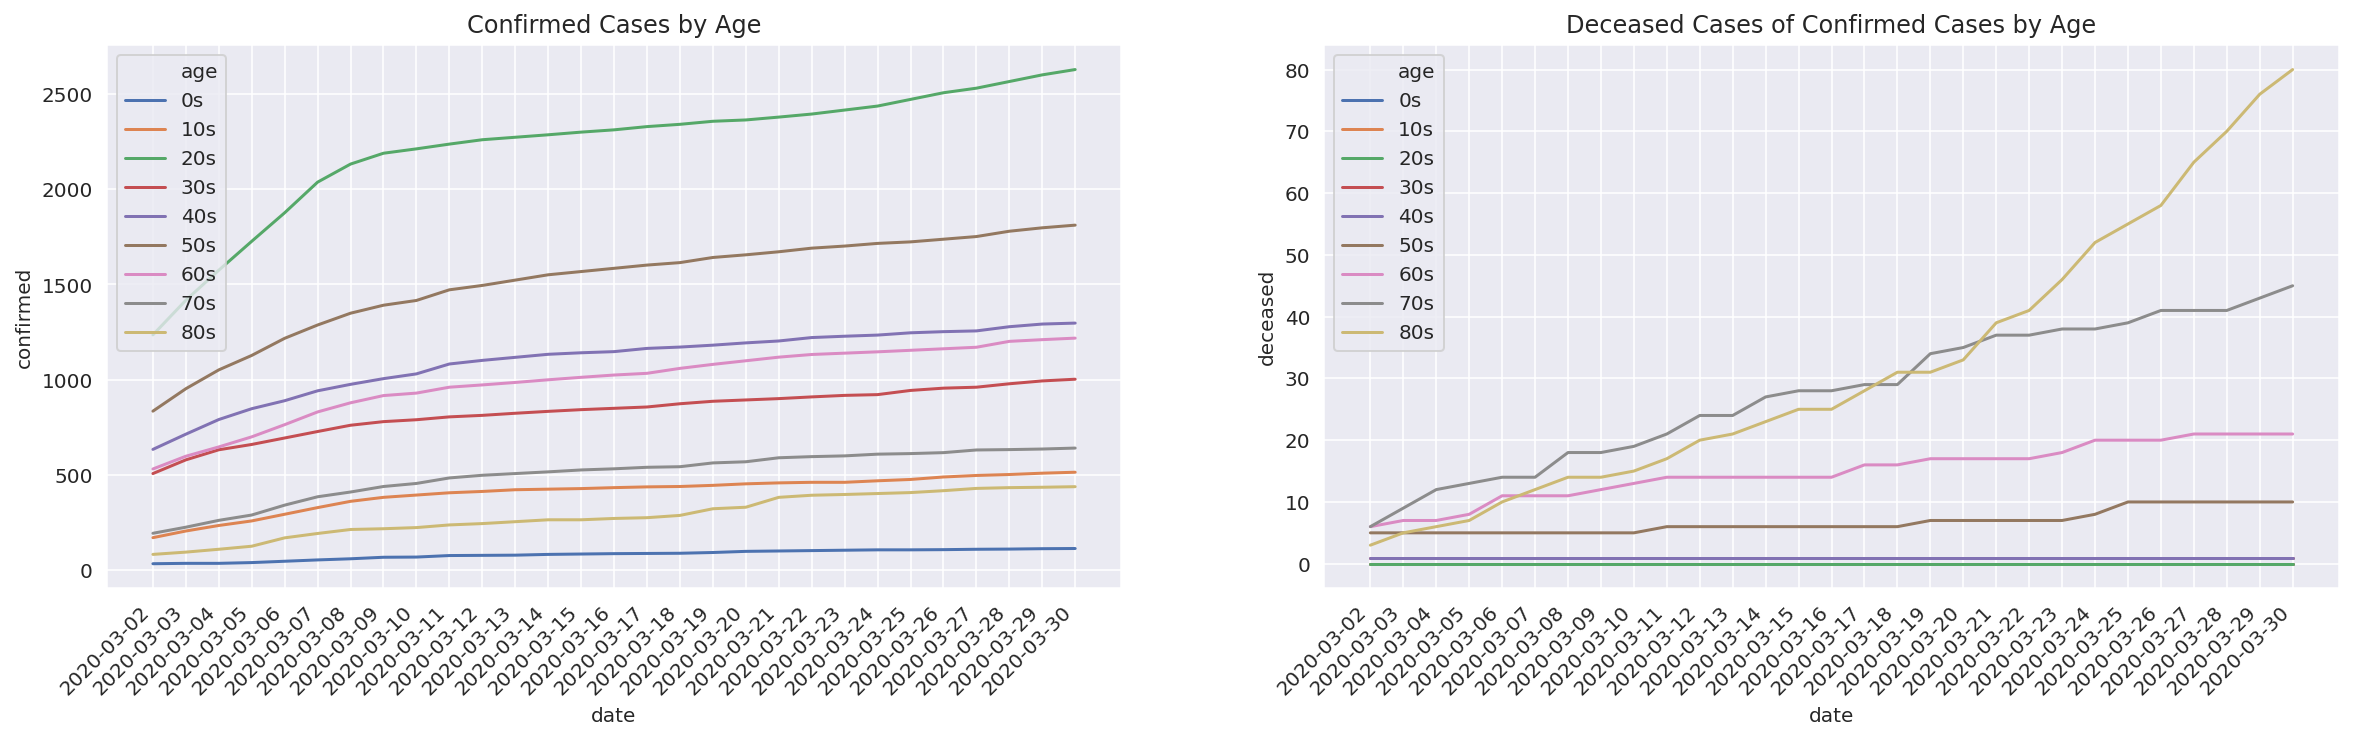

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Confirmed cases by age
ax1.title.set_text('Confirmed Cases by Age')
sns.lineplot(data=age, x='date', y='confirmed', hue='age', ax=ax1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Deceased cases by age
ax2.title.set_text('Deceased Cases of Confirmed Cases by Age')
sns.lineplot(data=age, x='date', y='deceased', hue='age', ax=ax2)
plt.xticks(rotation=45, ha='right')

plt.show()

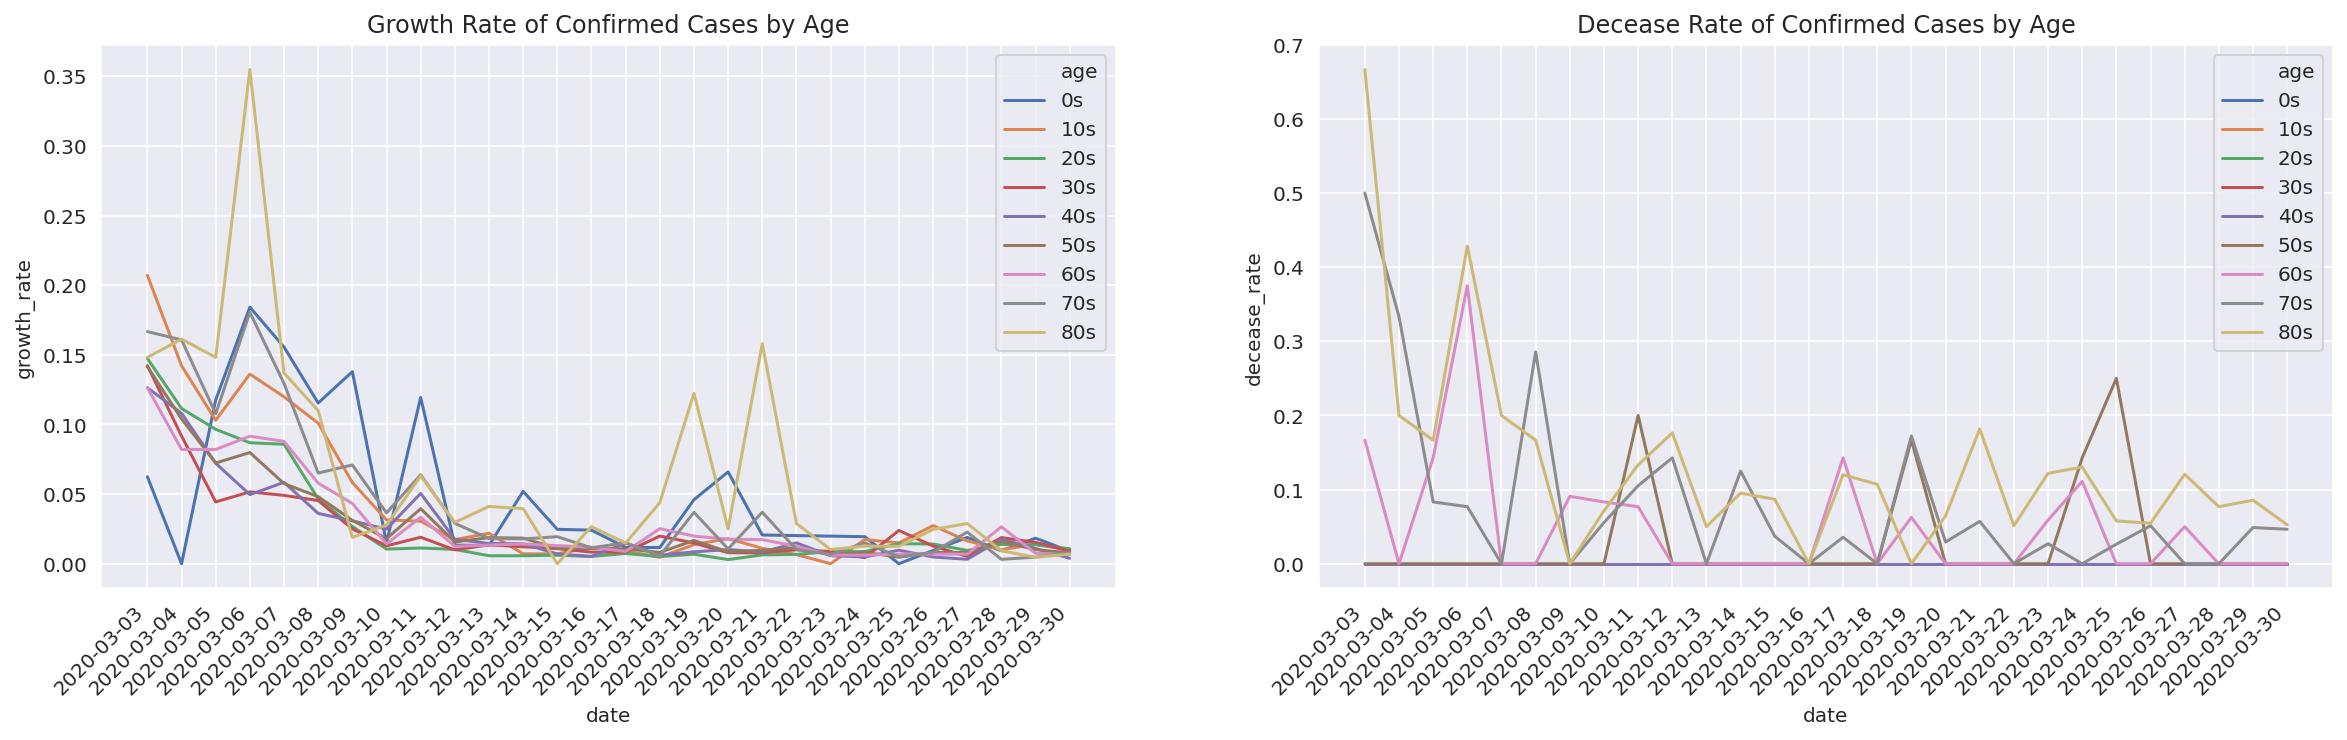

In [44]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Growth rate of confirmed cases
ax1.title.set_text('Growth Rate of Confirmed Cases by Age')
age['growth_rate'] = age.groupby('age')[['confirmed']].pct_change()
sns.lineplot(data=age, x='date', y='growth_rate', hue='age', ax=ax1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Decease rate of confirmed cases
ax2.title.set_text('Decease Rate of Confirmed Cases by Age')
age['decease_rate'] = age.groupby('age')[['deceased']].pct_change()
sns.lineplot(data=age, x='date', y='decease_rate', hue='age', ax=ax2)
plt.xticks(rotation=45, ha='right')

plt.show()

### **Analysis**

1. Although 20s only take up 13.2% of all populations in South Korea, they are the most infected and has the highest infection rate among all other age groups.
2. Older people are more prone to get COVID-19 and are more likely to get deceased.
3. Trend of growth and decease rate seems similar.

### **Conclusion**

Age seems to be a significant feature that influences infection rate.<br>High infection rate of age group 20s can might be explained by their social activeness as young people tend to move around places more than older people.<br>As people get older, their immunity tends to drop, which might be the reason why there are more cases of infections as people age.